In [1]:
library(ape)
library(tidyverse)
library(glue)

library(phytools)

library(caper)
library(lme4)
library(lmerTest)
library(lmtest)

library(LaplacesDemon)
library(MASS)
library(glmmTMB)
library(DHARMa)

library(caTools)
library(car)
library(quantmod)
library(MASS)
library(corrplot)
library(performance)

options(xts.warn_dplyr_breaks_lag = FALSE)
library(comprehenr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::where()  masks ape::where()
Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: mvtnorm

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:st

In [2]:
do_weighted = FALSE
do_geo = FALSE

max_missing_threshold = 0.5
min_classified_threshold = 5
min_poly_threhold = 2
min_di_threshold = 2

weighted_str = "unweighted" 
if (do_weighted)
    {
    weighted_str = "weighted" 
}

geo_str = ""
if (do_geo)
    {
    geo_str = "and_geodata_"
    }

features_of_interest = c("null_standardized_weighted.NODF", # nestedness measures
                     "null_standardized_weighted.connectance", 
                     "null_standardized_modularity",
                     "null_standardized_robustness.LL") # robustness of plants,  based on memmot 2004

data_path <- glue("../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_{geo_str}on_{weighted_str}_networks.csv")
res_path = glue("../../../data/statistical_analysis/network_level/test_results_{geo_str}on_{weighted_str}_networks.csv")

data <- read.csv(data_path)
rownames(data) <- data$network_id
names(data)<-make.names(names(data),unique = TRUE)
data <- filter(data, is_polyploid_missing_frac <= max_missing_threshold & 
               num_classified >= min_classified_threshold &
               num_polyploids >= min_poly_threhold & 
               num_diploids >= min_di_threshold)
print(paste("# networks for analysis = ", nrow(data)))

[1] "# networks for analysis =  260"


In [3]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

test_ploidy_freq_effect <- function(response_var){
    fixed_covars = c("is_polyploid_poly_frac", "network_size", "pd")
    random_covars = c("highest_rank_name")
                      # "Max.Temperature.of.Warmest.Month", 
                      #     "Min.Temperature.of.Coldest.Month",
                      #     "Annual.Precipitation",
                      #     "Precipitation.of.Wettest.Quarter",
                      #     "Precipitation.of.Driest.Quarter")
    if (do_geo)
        {
        random_covars = c("highest_rank_name", 
                          "EcoRegion", # choice of features is inspired by Beniaga et al. 2020
                          )
        }
    
    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
    print(complete_formula_str)
    complete_formula = as.formula(complete_formula_str)
    
    model.full <- lmer(formula=complete_formula, 
                 , data=data
                 )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = as.data.frame(model_res$coefficients)
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) gsub('[^[:alpha:]^_]', '', item))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = ifelse(fixed_covars != fixed_var, fixed_covars, "")
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- lmer(formula=as.formula(formula_str), 
                 , data=data
                 )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                   
    for (random_var in random_covars)
    {
        if (random_var != "sample_id")
        {
            subset_random_covars = random_covars[which(random_covars != random_var)]
            fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
            random_covars_formula_str = paste0("(1|", paste0(as.list(subset_random_covars), collapse = ") + (1|"), ")")
            formula_str = paste0(response_var, ' ~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
            model.reduced <- lmer(formula=as.formula(formula_str)
                            , data=data
                            )
            lrt <- anova(model.full, model.reduced)
            res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
            res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
        }
    }
    return (res_df)
}

# nestedness

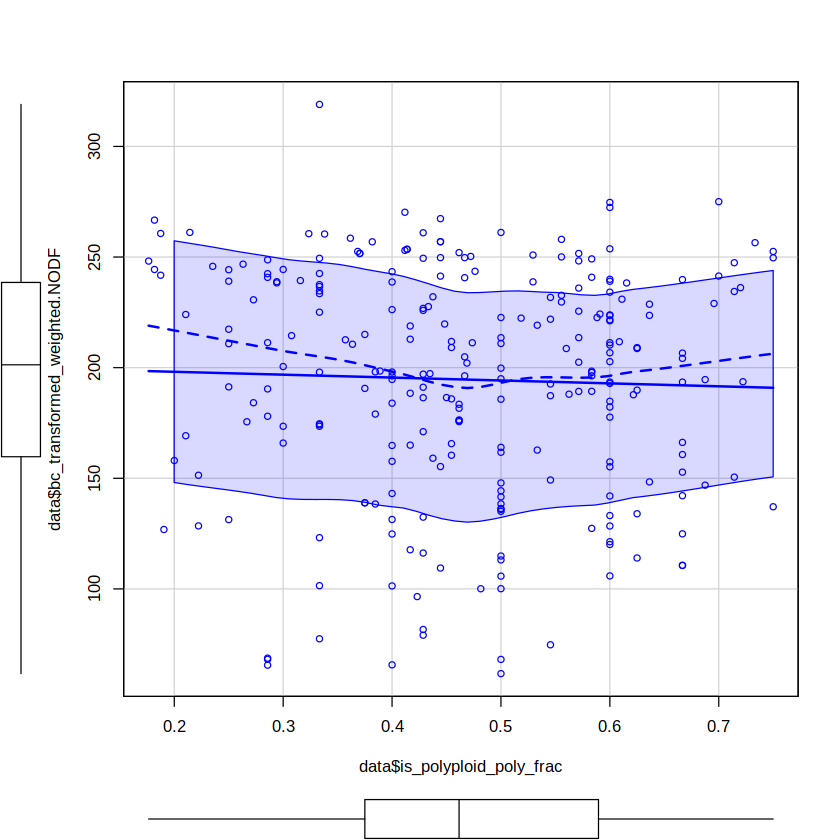

In [4]:
scatterplot(data$is_polyploid_poly_frac, data$bc_transformed_weighted.NODF)

[1] "bc_transformed_weighted.NODF~ is_polyploid_poly_frac + network_size + pd + (1|highest_rank_name)"
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: complete_formula
   Data: data

REML criterion at convergence: 2750.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.51650 -0.64714  0.07877  0.74871  2.79187 

Random effects:
 Groups            Name        Variance Std.Dev.
 highest_rank_name (Intercept)  258.2   16.07   
 Residual                      2400.3   48.99   
Number of obs: 260, groups:  highest_rank_name, 7

Fixed effects:
                        Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)            197.69199   17.19419  30.27463  11.498 1.43e-12 ***
is_polyploid_poly_frac   2.45166   22.67533 255.87423   0.108    0.914    
network_size             0.16003    0.03521 255.99840   4.545 8.49e-06 ***
pd                      -0.21393    1.23134 255.75027  -0.174    0.862    
---
Signif. cod

Warning message in anova.lm(lm(resp ~ group)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)

refitting model(s) with ML (instead of REML)



ERROR: Error in str2lang(x): <text>:1:80: unexpected ')'
1: bc_transformed_weighted.NODF ~ is_polyploid_poly_frac + network_size + pd + (1|)
                                                                                   ^


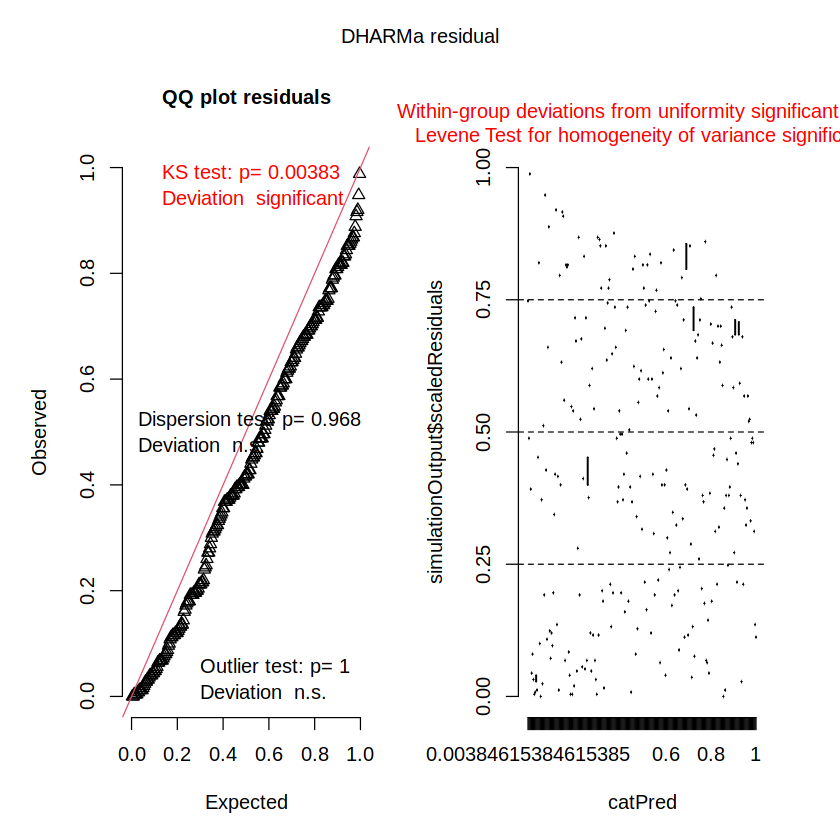

In [5]:
nest_res_df = test_ploidy_freq_effect("bc_transformed_weighted.NODF")

In [60]:
nest_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,NA
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Annual.Precipitation,bc_transformed_weighted.NODF,random,1.073951e-03,0.973857046,NA,NA,NA,NA,NA
EcoRegion,bc_transformed_weighted.NODF,random,4.260282e+00,0.039013434,NA,NA,NA,NA,NA
highest_rank_name,bc_transformed_weighted.NODF,random,6.878054e-11,0.999993383,NA,NA,NA,NA,NA
Intercept,bc_transformed_weighted.NODF,none,NA,NA,242.89133,49.64145,1.325784,4.8929137,0.08321559
is_polyploid_poly_frac,bc_transformed_weighted.NODF,fixed,3.356754e-02,0.854629747,24.29441,53.96735,52.351226,0.4501687,0.65444749
Max.Temperature.of.Warmest.Month,bc_transformed_weighted.NODF,random,1.073951e-03,0.973857046,NA,NA,NA,NA,NA
Min.Temperature.of.Coldest.Month,bc_transformed_weighted.NODF,random,1.073951e-03,0.973857046,NA,NA,NA,NA,NA
network_size,bc_transformed_weighted.NODF,random,1.073952e-03,0.973857041,NA,NA,NA,NA,NA
pd,bc_transformed_weighted.NODF,random,8.423219e+00,0.003704594,NA,NA,NA,NA,NA


# connectance

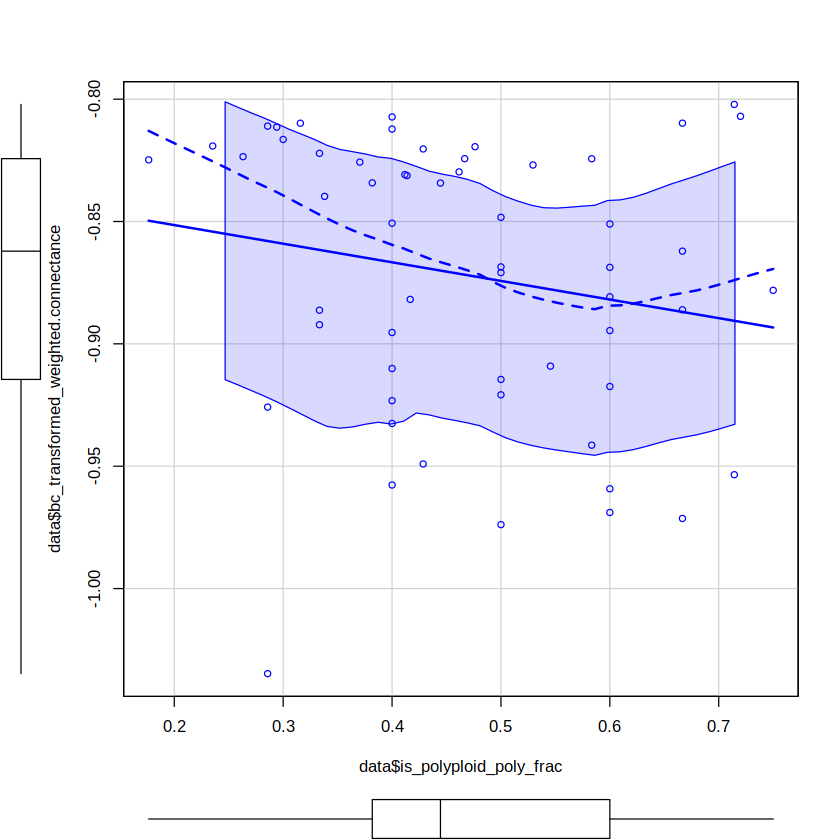

In [61]:
scatterplot(data$is_polyploid_poly_frac, data$bc_transformed_weighted.connectance)

[1] "bc_transformed_weighted.connectance~ is_polyploid_poly_frac + (1|network_size) + (1|pd) + (1|highest_rank_name) + (1|EcoRegion) + (1|Max.Temperature.of.Warmest.Month) + (1|Min.Temperature.of.Coldest.Month) + (1|Annual.Precipitation) + (1|Precipitation.of.Wettest.Quarter) + (1|Precipitation.of.Driest.Quarter)"


boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: complete_formula
   Data: data

REML criterion at convergence: -178.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.02082 -0.24725  0.09145  0.20640  0.96028 

Random effects:
 Groups                           Name        Variance  Std.Dev. 
 pd                               (Intercept) 1.108e-03 3.329e-02
 network_size                     (Intercept) 5.519e-12 2.349e-06
 Precipitation.of.Driest.Quarter  (Intercept) 5.736e-13 7.574e-07
 Precipitation.of.Wettest.Quarter (Intercept) 9.243e-13 9.614e-07
 Annual.Precipitation             (Intercept) 1.623e-12 1.274e-06
 Min.Temperature.of.Coldest.Month (Intercept) 0.000e+00 0.000e+00
 Max.Temperature.of.Warmest.Month (Intercept) 0.000e+00 0.000e+00
 EcoRegion                        (Intercept) 1.969e-03 4.438e-02
 highest_rank_name                (Intercept) 0.000e+00 0.000e+00
 Residual                                     

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 4 negative eigenvalues: -1.1e-05 -1.1e-05 -1.1e-05 -1.1e-05”
refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('i

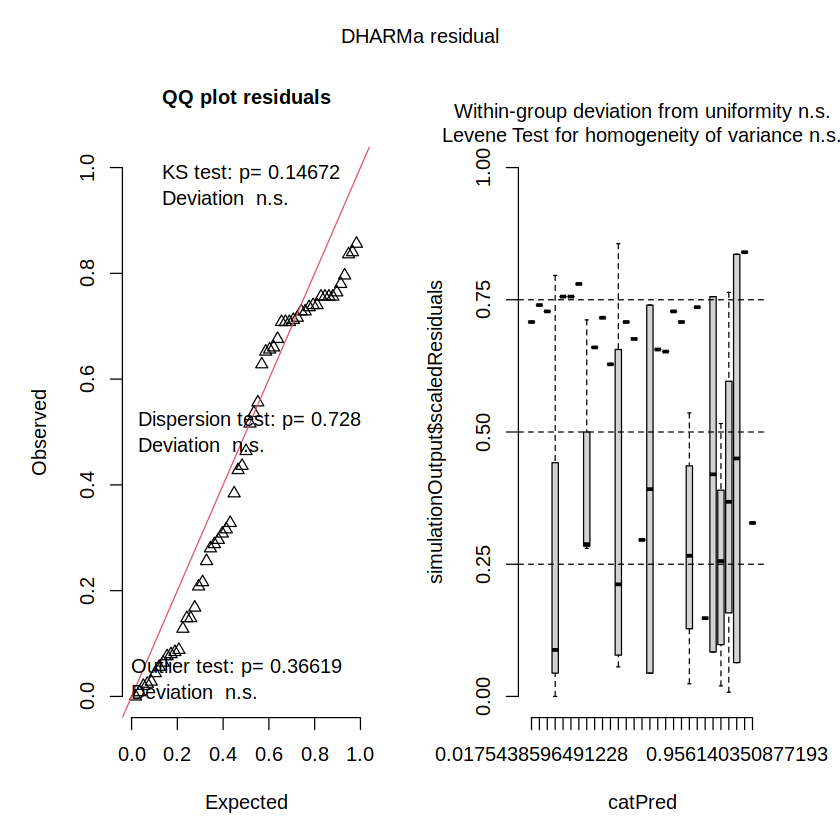

In [62]:
cont_res_df = test_ploidy_freq_effect("bc_transformed_weighted.connectance")

In [63]:
cont_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,NA
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Annual.Precipitation,bc_transformed_weighted.connectance,random,1.705303e-13,0.99999967,NA,NA,NA,NA,NA
EcoRegion,bc_transformed_weighted.connectance,random,6.399122e+00,0.01141768,NA,NA,NA,NA,NA
highest_rank_name,bc_transformed_weighted.connectance,random,7.503331e-12,0.99999781,NA,NA,NA,NA,NA
Intercept,bc_transformed_weighted.connectance,none,NA,NA,-0.8558662685,0.02432660,52.27236,-35.18231625,4.559456e-38
is_polyploid_poly_frac,bc_transformed_weighted.connectance,fixed,1.129198e-04,0.99152154,0.0008738279,0.04685245,50.78807,0.01865063,9.851929e-01
Max.Temperature.of.Warmest.Month,bc_transformed_weighted.connectance,random,1.705303e-13,0.99999967,NA,NA,NA,NA,NA
Min.Temperature.of.Coldest.Month,bc_transformed_weighted.connectance,random,1.705303e-13,0.99999967,NA,NA,NA,NA,NA
network_size,bc_transformed_weighted.connectance,random,0.000000e+00,1.00000000,NA,NA,NA,NA,NA
pd,bc_transformed_weighted.connectance,random,1.042883e+00,0.30715186,NA,NA,NA,NA,NA


# modularity

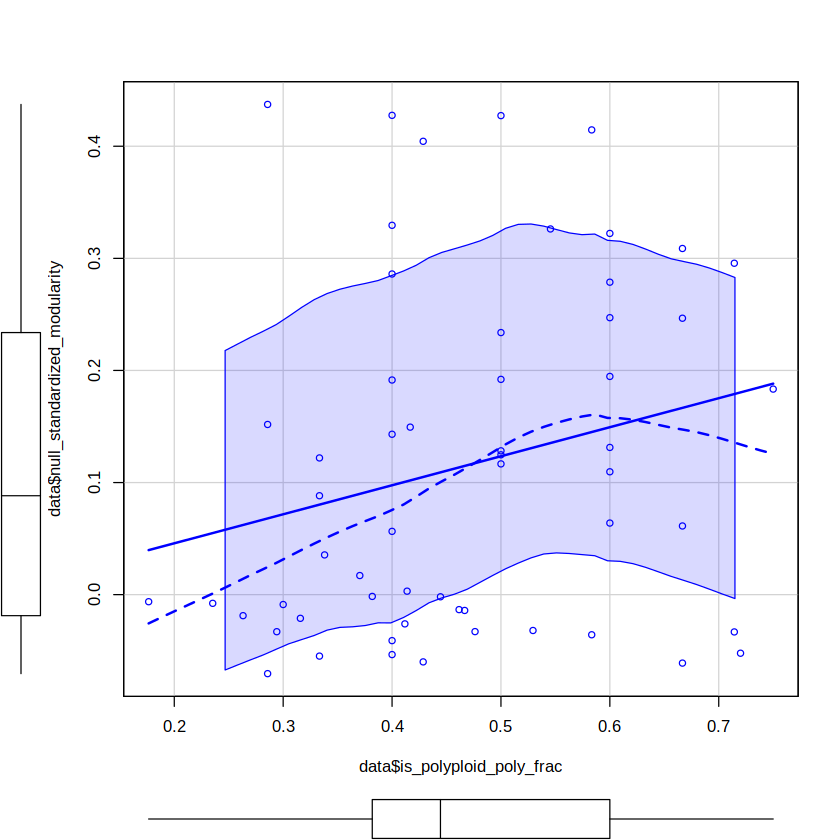

In [64]:
scatterplot(data$is_polyploid_poly_frac, data$null_standardized_modularity)

[1] "null_standardized_modularity~ is_polyploid_poly_frac + (1|network_size) + (1|pd) + (1|highest_rank_name) + (1|EcoRegion) + (1|Max.Temperature.of.Warmest.Month) + (1|Min.Temperature.of.Coldest.Month) + (1|Annual.Precipitation) + (1|Precipitation.of.Wettest.Quarter) + (1|Precipitation.of.Driest.Quarter)"


boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 3 negative eigenvalues: -6.6e-03 -5.5e-02 -1.4e-01”


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: complete_formula
   Data: data

REML criterion at convergence: -71.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-0.72638 -0.02871 -0.01127  0.04021  0.68172 

Random effects:
 Groups                           Name        Variance  Std.Dev. 
 pd                               (Intercept) 1.029e-02 1.015e-01
 network_size                     (Intercept) 1.951e-10 1.397e-05
 Precipitation.of.Driest.Quarter  (Intercept) 1.174e-11 3.426e-06
 Precipitation.of.Wettest.Quarter (Intercept) 0.000e+00 0.000e+00
 Annual.Precipitation             (Intercept) 0.000e+00 0.000e+00
 Min.Temperature.of.Coldest.Month (Intercept) 2.268e-10 1.506e-05
 Max.Temperature.of.Warmest.Month (Intercept) 1.693e-10 1.301e-05
 EcoRegion                        (Intercept) 1.664e-02 1.290e-01
 highest_rank_name                (Intercept) 5.791e-04 2.406e-02
 Residual                                     3

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 3 negative eigenvalues: -4.8e-02 -4.8e-02 -2.0e-01”
refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)

boundary (singular) fit: see help('isSingular')

Warning message:
“Model failed to converge with 3 negative eigenvalues: -4.9e-03 -4.9e-02 -6.4e-01”
refitting model(s) with ML (instead of REML)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 5 negative eigenvalues”
Warning message:
“Model failed to converge with 4 negative eigenvalues: -1.9e-07 -1.9e-07 -2.0e-07 -3.5e-07”
refitting model(s) with 

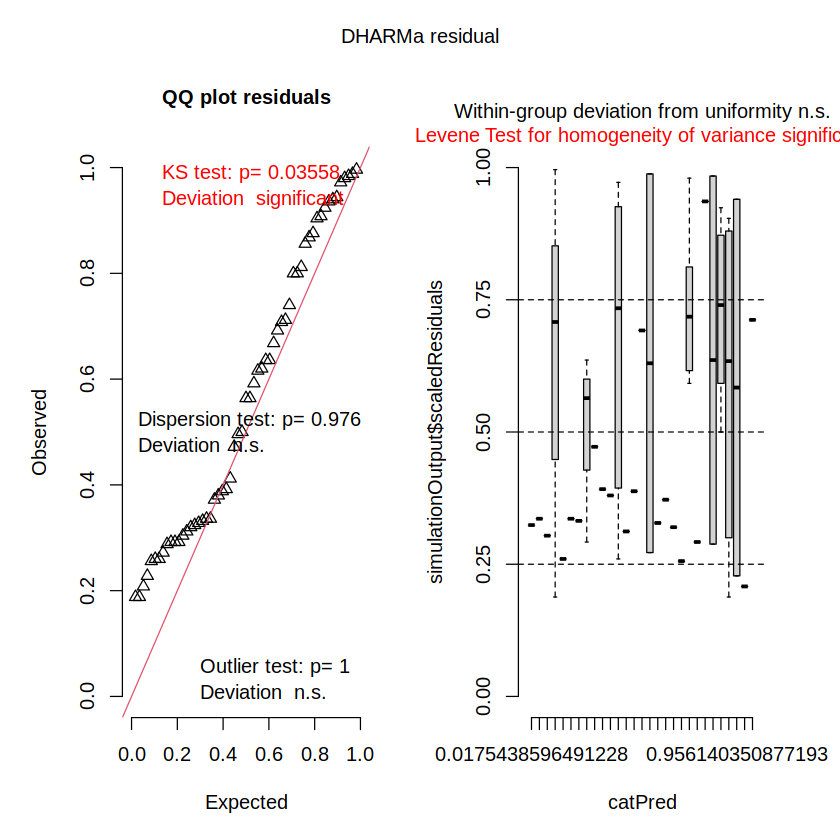

In [65]:
modul_res_df = test_ploidy_freq_effect("null_standardized_modularity")

In [66]:
modul_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,NA
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Annual.Precipitation,null_standardized_modularity,random,0.000000e+00,1.000000000,NA,NA,NA,NA,NA
EcoRegion,null_standardized_modularity,random,7.793654e+00,0.005243005,NA,NA,NA,NA,NA
highest_rank_name,null_standardized_modularity,random,0.000000e+00,1.000000000,NA,NA,NA,NA,NA
Intercept,null_standardized_modularity,none,NA,NA,0.04393921,0.06979661,1.125704,0.6295321,0.6325309
is_polyploid_poly_frac,null_standardized_modularity,fixed,2.526765e-01,0.615196741,0.06068385,0.12797072,47.977296,0.4742010,0.6375077
Max.Temperature.of.Warmest.Month,null_standardized_modularity,random,0.000000e+00,1.000000000,NA,NA,NA,NA,NA
Min.Temperature.of.Coldest.Month,null_standardized_modularity,random,0.000000e+00,1.000000000,NA,NA,NA,NA,NA
network_size,null_standardized_modularity,random,8.526513e-13,0.999999263,NA,NA,NA,NA,NA
pd,null_standardized_modularity,random,3.651122e+00,0.056031454,NA,NA,NA,NA,NA


In [67]:
full_df = rbind(rbind(nest_res_df, cont_res_df), modul_res_df)

In [68]:
full_df["significant_by_lrt"] = full_df$lrt_pvalue <= 0.05
full_df["significant_by_wald_test"] = full_df$z_test_pvalue <= 0.05

In [69]:
write.csv(full_df, res_path)

In [70]:
round_df <- function(df, digits = 5) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))

  df[,nums] <- round(df[,nums], digits = digits)

  (df)
}

round_df(full_df)

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,NA,significant_by_lrt,significant_by_wald_test
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Annual.Precipitation,bc_transformed_weighted.NODF,random,0.00107,0.97386,NA,NA,NA,NA,NA,FALSE,NA
EcoRegion,bc_transformed_weighted.NODF,random,4.26028,0.03901,NA,NA,NA,NA,NA,TRUE,NA
highest_rank_name,bc_transformed_weighted.NODF,random,0.00000,0.99999,NA,NA,NA,NA,NA,FALSE,NA
Intercept,bc_transformed_weighted.NODF,none,NA,NA,242.89133,49.64145,1.32578,4.89291,0.08322,NA,FALSE
is_polyploid_poly_frac,bc_transformed_weighted.NODF,fixed,0.03357,0.85463,24.29441,53.96735,52.35123,0.45017,0.65445,FALSE,FALSE
Max.Temperature.of.Warmest.Month,bc_transformed_weighted.NODF,random,0.00107,0.97386,NA,NA,NA,NA,NA,FALSE,NA
Min.Temperature.of.Coldest.Month,bc_transformed_weighted.NODF,random,0.00107,0.97386,NA,NA,NA,NA,NA,FALSE,NA
network_size,bc_transformed_weighted.NODF,random,0.00107,0.97386,NA,NA,NA,NA,NA,FALSE,NA
pd,bc_transformed_weighted.NODF,random,8.42322,0.00370,NA,NA,NA,NA,NA,TRUE,NA
